#Installations

In [ ]:
!pip install sdv

In [ ]:
!pip install sdmetrics

#Imports

In [ ]:
import pandas as pd

# Models
from sdv import Metadata
from sdv.relational import HMA1
from sdv.tabular import CTGAN

# Saving/Loading models
import pickle

# Constraints
from sdv.constraints import FixedCombinations, Unique, Inequality

# Metrics
#from sdmetrics.reports.single_table import DiagnosticReport
from sdmetrics.reports.multi_table import QualityReport
from sdv.metrics.relational import KSComplement
from sdmetrics.multi_table import CardinalityShapeSimilarity
from sdv.evaluation import evaluate

# Timings
import time
import datetime

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Load data

In [ ]:
# Load multi-table dataset
customers = pd.read_csv("drive/MyDrive/PTUT - Synthetic/Data_Synthetic_Large/customers.csv")customers.csv, order_items.csv, order_statuses.csv, orders_dummy.csv, products.csv
order_items = pd.read_csv("drive/MyDrive/PTUT - Synthetic/Data_Synthetic_Large/order_items.csv")
order_statuses = pd.read_csv("drive/MyDrive/PTUT - Synthetic/Data_Synthetic_Large/order_statuses.csv")
orders = pd.read_csv("drive/MyDrive/PTUT - Synthetic/Data_Synthetic_Large/orders_dummy.csv", sep=";")
products = pd.read_csv("drive/MyDrive/PTUT - Synthetic/Data_Synthetic_Large/products.csv")
shippers = pd.read_csv("drive/MyDrive/PTUT - Synthetic/Data_Synthetic_Large/shippers_dummy.csv")

# can't have float as id (NaN values cause ints to become floats in this case)
#orders['shipper_id'] = orders['shipper_id'].astype(float).astype('Int64')

# Ensure datetime format
orders['order_date'] = pd.to_datetime(orders['order_date'])
orders['shipped_date'] = pd.to_datetime(orders['shipped_date'])

#Build metadata

In [ ]:
# create dictionnary with tables: used for creating metadata
tables = dict(customers=customers, order_items=order_items, order_statuses=order_statuses, orders=orders, products=products, shippers=shippers)

In [ ]:
# create empty metadata object
metadata = Metadata()

In [ ]:
# create constraint: ensure correct city/state combination
city_state_constraint = FixedCombinations(column_names=['city', 'state'])

In [ ]:
# add customers table to metadata
metadata.add_table(
    name='customers',
    data=tables['customers'],
    primary_key='customer_id',
    fields_metadata={'address': {'type': 'categorical', 'pii': True, 'pii_category': 'street_address'}, 
                     'phone': {'type': 'categorical', 'pii': True, 'pii_category': 'phone_number'},
                     'first_name': {'type': 'categorical', 'pii': True, 'pii_category': 'first_name'},
                     'last_name': {'type': 'categorical', 'pii': True, 'pii_category': 'last_name'},
                     'birth_date': {'type': 'categorical', 'pii': True, 'pii_category': 'date_of_birth'}},
    constraints=[city_state_constraint]
)

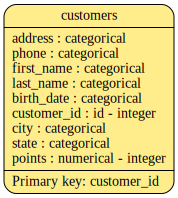

In [ ]:
# Visualize the added customers table
metadata.visualize()

In [ ]:
# create constraint: ensure ordre_date < shipped_date
date_constraint = Inequality('order_date', 'shipped_date')

In [ ]:
# add child table: orders
metadata.add_table(
    name='orders',
    data=tables['orders'],
    primary_key='order_id',
    parent='customers',
    foreign_key='customer_id',
    #constraints=[date_constraint]
)

In [ ]:
# create constraint: ensure shippers have unique names
shipper_constraint = Unique(column_names=['name'])

In [ ]:
# Add shipper table
metadata.add_table(
    name='shippers',
    data=tables['shippers'],
    primary_key='shipper_id',
    constraints=[shipper_constraint]
)

In [ ]:
# Add relationship between shippers and orders
metadata.add_relationship('shippers', 'orders', 'shipper_id')

In [ ]:
# create constraint: ensure statuses are unique
order_status_constraint = Unique(column_names=['name'])

In [ ]:
# Add order statuses table
metadata.add_table(
    name='order_statuses',
    data=tables['order_statuses'],
    primary_key='order_status_id',
    constraints=[order_status_constraint]
)

In [ ]:
# Add relationship between order_statuses and orders
metadata.add_relationship('order_statuses', 'orders', 'status')

In [ ]:
# create constraint: ensure product names are unique
product_constraint = Unique(column_names=['name'])

In [ ]:
# Add products table
metadata.add_table(
    name='products',
    data=tables['products'],
    primary_key='product_id',
    constraints=[product_constraint]
)

In [ ]:
# Add order item table
metadata.add_table(
    name='order_items',
    data=tables['order_items'],
    primary_key='id'
)

In [ ]:
# Add relashionships

metadata.add_relationship('orders', 'order_items', 'order_id')
metadata.add_relationship('products', 'order_items', 'product_id')

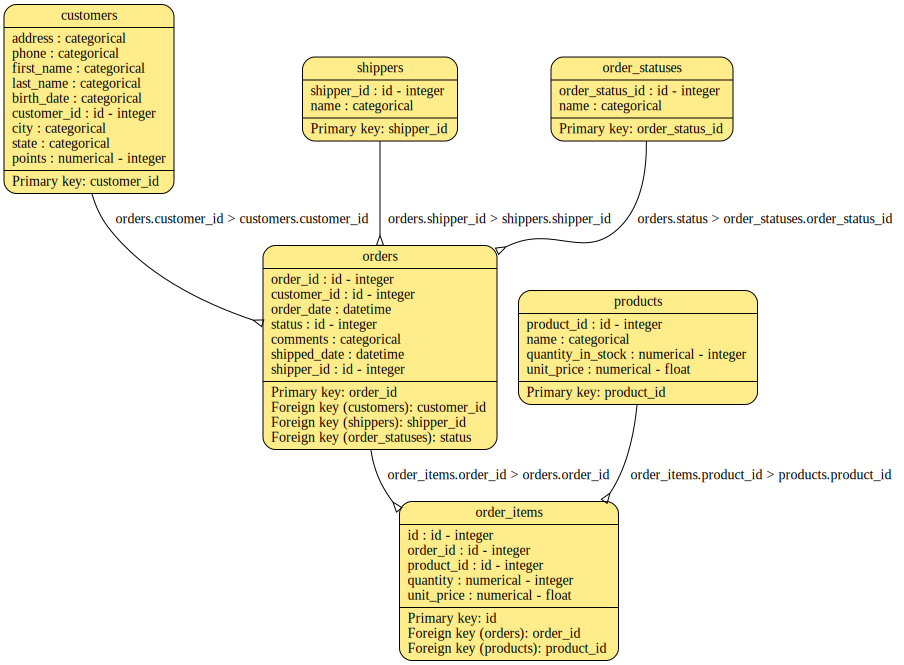

In [ ]:
# Visualize the metadata: data model

metadata.visualize()

#Train the model

In [ ]:
# Fit multi-table model

model = HMA1(metadata)

# time process
start_time = time.time()

# fit model
model.fit(tables)

end_time = time.time()

In [ ]:
# Get training time
str(datetime.timedelta(end_time - start_time))

162.91229224205017

#Save/Load the model

In [ ]:
# Save model
model.save('multi_table_model.pkl')

In [ ]:
# Load model
model = pickle.load(open('/content/drive/MyDrive/PTUT - Synthetic/multi_table_model.pkl', 'rb'))

#Generate new sample

In [ ]:
# Generate new data
synthetic_data = model.sample()

N.B. The quality and diagnostic reports can be found in the "Lecteur rapport" files